In [13]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

from scripts.main_mnist import load_mnist_data

try: #allows for updates externally
    del sys.modules["test_utils"]
    del sys.modules["generator"]
except:
    pass
import test_utils as utils
from api.generator import Generator

In [14]:
#showing func names only longer than 5 character to avoid nn(), torch(), plt(), ...
print("utils functions:\n  "+"()\n  ".join([m for m in dir(utils) if m[0]!="_" and len(m)>5])+"()")

utils functions:
  Generator()
  check_input()
  criterion()
  dic_find()
  empty_prototypes()
  find_prototypes()
  generate_prototypes()
  get_best_prototypes()
  get_digit()
  get_prototypes()
  load_model()
  plot_activations()
  show_digit()
  show_model_specs()
  visualize_best()
  visualize_cpts()
  visualize_reconstruction()


# MODEL & DATA

In [15]:
#LOAD MODEL
model = utils.load_model(h_type="cnn", nconcepts=5, reg_lambda=0.1, show_specs=True)
model.eval()
for param in model.parameters():
    param.requires_grad = False
#LOAD DATA
train_loader, valid_loader, test_loader, train, test = load_mnist_data(batch_size=1,num_workers=4)

Loading MNIST model:
  conceptizer type        = cnn
  number of concepts      = 5
  sparsity parameter      = 2e-05
  regularization strength = 1e-01


# VISUALIZE AUTOENCODER IN/OUT 

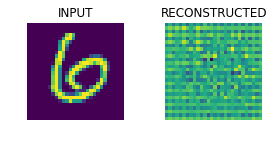

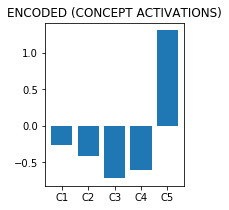

In [16]:
utils.visualize_reconstruction(model, test, 11)
#here you can see that reconstruction does a shit job

# VISUALIZE CONCEPT ACTIVATIONS
### USING DATASAMPLES

Paper uses: 
$$X^i={\arg\max} _{\hat{X}\subseteq X,|\hat{X}|=l}\sum_{x\in\hat{X}}h(x)_i$$
They propose to make synthetic images:
$$x={\arg\max} _{x\in\mathcal{X}}h_i(x)-\sum_{j\neq i}h_j(x)$$
    

In [17]:
#dataset=train : 60000 samples - slow
#dataset=test  : 10000 samples - fast
#2nd arg can be lowered to speed it up as well
prototypes_data, _ = utils.get_prototypes(model, 3, dataset=train, print_freq=7500)

Finding prototypes according to the method used in the paper:
0/60000
7500/60000
15000/60000
22500/60000
30000/60000
37500/60000
45000/60000
52500/60000
60000/60000


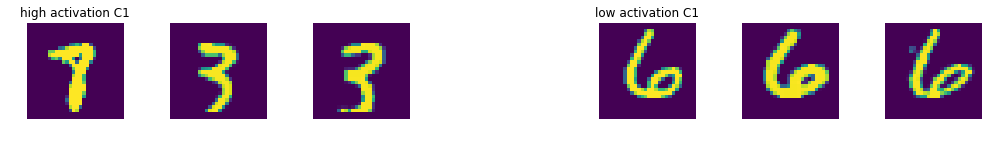

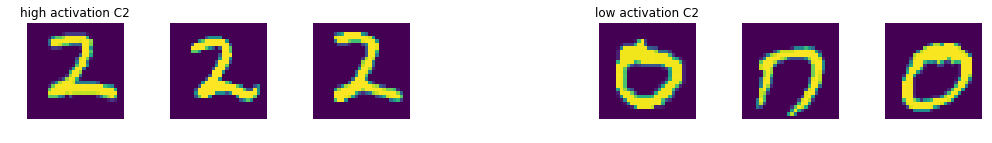

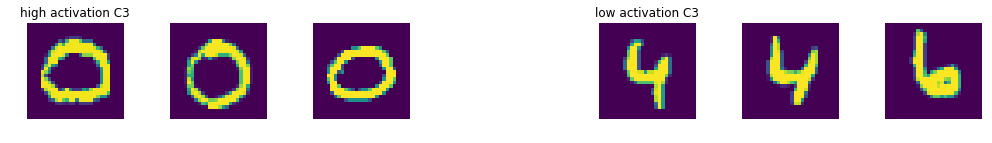

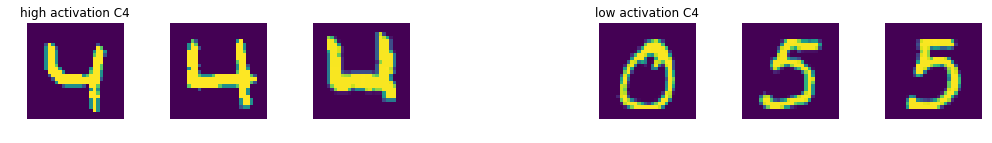

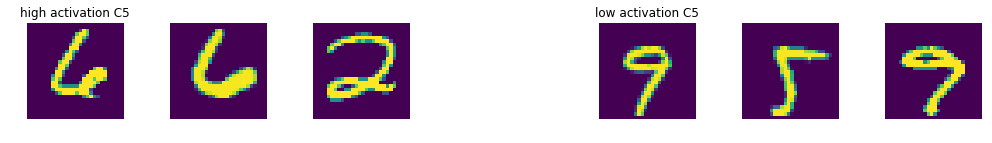

In [18]:
utils.visualize_cpts(prototypes_data, imsize = 2)

### USING GENERATED IMAGES

In [19]:
#param p1: determines how much the activation of the other concepts influence the loss (higher is more)
#param p2: determines how strong the the generator is forced to produce images x such that x ~ N(0,1)
prototypes_gen, losses = utils.get_prototypes(model, 1, Nsteps=100, lr=0.1, p1=.1, p2=10)

Generating synthetic images that maximize the activations:
1/5
2/5
3/5
4/5
5/5


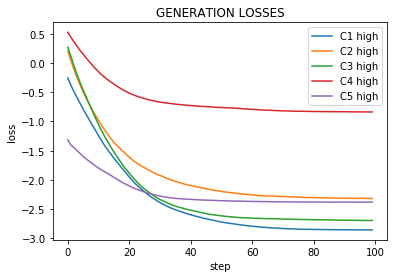

In [20]:
#let's plot some of the losses
#use this to adjust learning rate lr and Nsteps
plt_extreme = "high"
plotted = 0
for cpt in losses.keys():
    for sample in losses[cpt][plt_extreme].keys():
        plt.plot(losses[cpt][plt_extreme][sample], label=f"C{cpt+1} {plt_extreme}")
        plt.title("GENERATION LOSSES")
        plt.ylabel("loss")
        plt.xlabel("step")
        plotted += 1
        break
    if plotted == 5:
        break
plt.legend()
plt.show()

In [21]:
check_cpt = 1

#can force the mean and stv to 0 and 1 by increasing p2
check_high = list(prototypes_gen[check_cpt]["high"].keys())[0]
check_low = list(prototypes_gen[check_cpt]["low"].keys())[0]
print("means -  HIGH: {:<5.2}   LOW: {:.2}".format(torch.mean(check_high),torch.mean(check_low)))
print("stdvs -  HIGH: {:<5.2}   LOW: {:.2}".format(torch.std(check_high),torch.std(check_low)))

means -  HIGH: 0.0066   LOW: 0.0044
stdvs -  HIGH: 1.1     LOW: 1.1


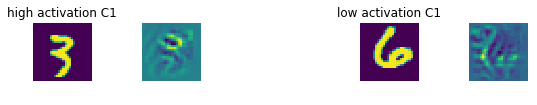

     1.46         2.93                     -0.808       -1.73        


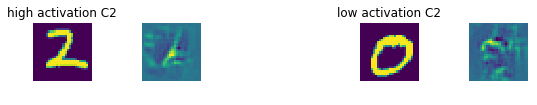

     1.26          2.5                      -1.45       -2.36        


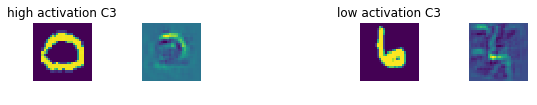

     1.62         2.97                      -1.35       -2.62        


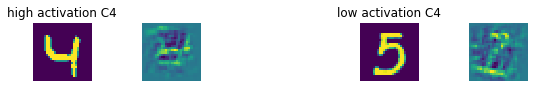

     0.558        0.86                      -1.14       -1.35        


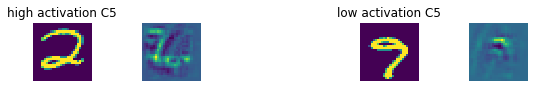

     1.89         2.18                      0.643       -0.13        


In [22]:
#plot the best prototypes of both methods and print their activations
prototypes_best = utils.get_best_prototypes(model, prototypes_data, prototypes_gen)
utils.visualize_best(prototypes_best)

In [23]:
#if you run this cell, this cool image will disappear
#it's the overlap of all digits